In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat

import pysindy as ps

# Quasiperiodic cavity flow

This example demonstrates the use of SINDy to learn a model for the quasiperiodic dynamics in a shear-driven cavity at Re=7500, following [Callaham, Brunton, and Loiseau (2021)](https://arxiv.org/abs/2106.02409).  As in the cylinder wake example (see notebook 3), the reduced-order model appproximates the 2D time-varying velocity field $\mathbf{u}(\mathbf{x}, t)$ with the POD expansion
$$
\mathbf{u}(\mathbf{x}, t) = \sum_{j=1}^r \boldsymbol{\psi}_j(\mathbf{x}) a_j(t).
$$
The POD expansion gives us the spatial modes $\boldsymbol{\psi}_j(\mathbf{x})$ and a time series for the coefficients $a_j(t)$.  This time series serves as the training data; if we can learn an ODE model
$$
\dot{\mathbf{a}} = \mathbf{f}(\mathbf{a})
$$
for the coefficients then we can evaluate the model cheaply and reconstruct the full velocity field.

The standard approach to this kind of reduced-order model is to construct a physics-based model for $\mathbf{f}(\mathbf{a})$ using a technique called _Galerkin projection_ (see the paper referenced above for details).  

__NOTE:__ Since the full Direct Numerical Solution (DNS) fields and POD modes are too large to store in a standard GitHub repository, we'll just start with the set of POD coefficients $\mathbf{a}(t)$.

In [2]:
# Load training data

dt = 0.02
r = 2
n = r + 1

data_run1 = loadmat("data/PODcoefficients.mat")
x_run1 = np.concatenate(
    (data_run1["alpha"][:5000, :r], data_run1["alphaS"][:5000, 0:1]), axis=1
)
t_run1 = np.arange(0, dt * x_run1.shape[0], dt)

data_run2 = loadmat("data/PODcoefficients_run1.mat")
x_run2 = np.concatenate(
    (data_run2["alpha"][:3000, :r], data_run2["alphaS"][:3000, 0:1]), axis=1
)
t_run2 = np.arange(0, dt * x_run2.shape[0], dt)

x_train = [x_run1, x_run2]
t_train = [t_run1, t_run2]

In [3]:
# Fit the model

optimizer = ps.STLSQ(threshold=1e-4)
library = ps.PolynomialLibrary(degree=5)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=["x", "y", "z"]
)
model.fit(x_train, t_train, multiple_trajectories=True, quiet=True)
model.print()

x' = -0.133 1 + -0.009 x + -1.023 y + -0.001 z + -0.002 y z
y' = -0.057 1 + 1.035 x + 0.005 y + 0.002 x z + -0.002 y z
z' = -20.653 1 + -0.294 z + 0.001 x^2 + 0.001 y^2 + -0.001 z^2


In [4]:
# Simulate the model

x_simulate_run1 = model.simulate(x_run1[0], np.arange(0, 100, 0.02))
x_simulate_run2 = model.simulate(x_run2[0], np.arange(0, 95, 0.02))

<ipython-input-5-a0520ebc2c55>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


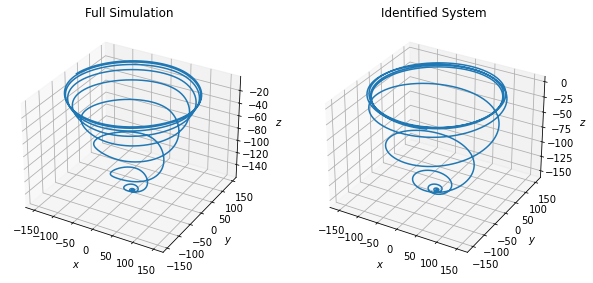

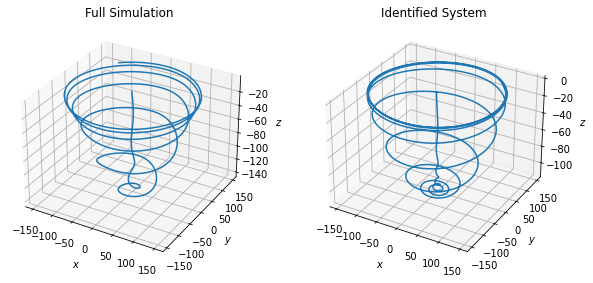

In [5]:
# Plot results

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run1[:, 0], x_run1[:, 1], x_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run1[:, 0], x_simulate_run1[:, 1], x_simulate_run1[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(121, projection="3d")
ax.plot(x_run2[:, 0], x_run2[:, 1], x_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Full Simulation")

ax = fig.add_subplot(122, projection="3d")
ax.plot(x_simulate_run2[:, 0], x_simulate_run2[:, 1], x_simulate_run2[:, 2])
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.title("Identified System")
fig.show()